In [92]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [93]:
root = 'e:/kaggle/ml_training/session4'

train_path = root + '/train'
valid_path = root + '/valid'
test_path = root + '/test'

batch_size = 10

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), 
                                                         classes=['dog', 'cat'], batch_size=batch_size)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), 
                                                         classes=['dog', 'cat'], batch_size=batch_size)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), 
                                                        classes=['dog', 'cat'], batch_size=batch_size)

Found 330 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [94]:
vgg16_model = keras.applications.vgg16.VGG16()

model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
    
model.layers.pop()

for layer in model.layers:
    layer.trainable = False
    
model.add(Dense(2, activation='softmax'))

model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_batches, steps_per_epoch=batch_size, 
                    validation_data=valid_batches, validation_steps=batch_size, epochs=5, verbose=2)

Epoch 1/5
 - 23s - loss: 0.6903 - accuracy: 0.6100 - val_loss: 0.6876 - val_accuracy: 0.4900
Epoch 2/5
 - 23s - loss: 0.6888 - accuracy: 0.6200 - val_loss: 0.6876 - val_accuracy: 0.5500
Epoch 3/5
 - 23s - loss: 0.6915 - accuracy: 0.6400 - val_loss: 0.7078 - val_accuracy: 0.5100
Epoch 4/5
 - 23s - loss: 0.6902 - accuracy: 0.6100 - val_loss: 0.7004 - val_accuracy: 0.5600
Epoch 5/5
 - 23s - loss: 0.6890 - accuracy: 0.6300 - val_loss: 0.6941 - val_accuracy: 0.5100


In [95]:
_, acc = model.evaluate_generator(valid_batches, steps=len(valid_batches), verbose=0)
print('> %.3f' % (acc * 100.0))

> 55.135


In [96]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

array([0., 0., 1., 1., 0., 1., 1., 0., 0., 0.], dtype=float32)

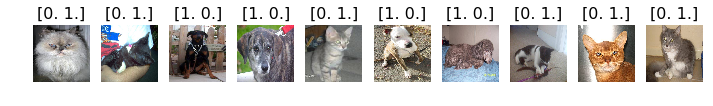

In [97]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

test_labels = test_labels[:,0]
test_labels

Confusion matrix, without normalization
[[3 3]
 [3 1]]


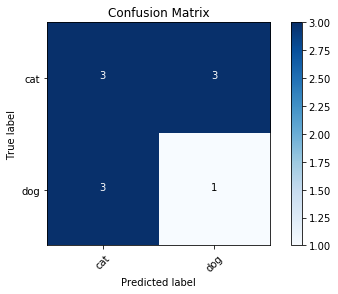

In [98]:
cm = confusion_matrix(test_labels, np.round(predictions)[:,0])

cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [84]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     